<a id='import_lib'></a>
# 1. Import Libraries

In [ ]:
# suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

# 'Os' module provides functions for interacting with the operating system 
import os

# 'Pandas' is used for data manipulation and analysis
import pandas as pd 

# 'Numpy' is used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# 'Matplotlib' is a data visualization library for 2D and 3D plots, built on numpy
import matplotlib.pyplot as plt
%matplotlib inline

# 'Seaborn' is based on matplotlib; used for plotting statistical graphics
import seaborn as sns

from math import radians, cos, sin, sqrt, asin

# 'Scikit-learn' (sklearn) emphasizes various regression, classification and clustering algorithms
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# set the plot size using 'rcParams'
# once the plot size is set using 'rcParams', it sets the size of all the forthcoming plots in the file
# pass width and height in inches to 'figure.figsize' 
plt.rcParams['figure.figsize'] = [15,8]

<a id='set_options'></a>
# 2. Set Options

In [ ]:
# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# returns an output value upto 6 decimals
pd.options.display.float_format = '{:.6f}'.format

<a id='Read_Data'></a>
# 3. Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read csv file using pandas
df_taxi = pd.read_csv('/content/drive/MyDrive/0.MKCE/5.Random Forest/2 Project/Taxi Fare Prediction/Dataset/TaxiFare.csv')

# display the top 5 rows of the dataframe
df_taxi.head()

# Note: To display more rows, example 10, use head(10)

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.500000,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.900000,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.700000,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.700000,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.300000,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


The column `unique_id` contains the unique identifier for each observation, which is redundant for further analysis. Thus, we drop this column.

In [ ]:
# drop the column 'Id' using drop()
# 'axis = 1' drops the specified column
df_taxi = df_taxi.drop('unique_id', axis = 1)

<a id='data_preparation'></a>
# 4. Prepare and Analyze the Data

<a id='Data_Understanding'></a>
## 4.1 Understand the Data

**Let us now see the number of variables and observations in the data.**

In [ ]:
# 'shape' returns the dimensions of the data
df_taxi.shape

(50000, 7)

We see the dataframe has 7 columns and 50000 rows. It means there are 7 variables and 50000 observations.

**1. Check the data type.**

In [ ]:
# use 'dtypes' to check the data type of each variable
df_taxi.dtypes

amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

**2. Change the incorrect data type.**

In [ ]:
# convert object to datetime using to_datetime method from pandas
#if error is set to'coerce', then invalid parsing will be set as NaT.
df_taxi.date_time_of_pickup = pd.to_datetime(df_taxi.date_time_of_pickup)

**3. Recheck the data type after the conversion.**

In [ ]:
# recheck the data type of each column
df_taxi.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object

<a id='Feature_Eng'></a>
### 4.1.2 Feature Engineering

We will extract date time features from the variable 'date_time_of_pickup'.

In [ ]:
# extract various date time components as seperate variables
df_taxi = df_taxi.assign(hour = df_taxi.date_time_of_pickup.dt.hour, 
                         day = df_taxi.date_time_of_pickup.dt.day,
                        month = df_taxi.date_time_of_pickup.dt.month, 
                        year = df_taxi.date_time_of_pickup.dt.year, 
                        dayofweek = df_taxi.date_time_of_pickup.dt.dayofweek)

We will add a new variable which measures the distance between the pickup and dropoff point. We will use the Haversine formula to compute the distance between two points of the journey, using the logitude and latitude values. 

In [ ]:
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [ ]:
#Add a new variable travel distance

df_taxi['travel_dist_km'] = distance_transform(df_taxi['longitude_of_pickup'].to_numpy(),
                                                df_taxi['latitude_of_pickup'].to_numpy(),
                                                df_taxi['longitude_of_dropoff'].to_numpy(),
                                                df_taxi['latitude_of_dropoff'].to_numpy()
                                              )

In [ ]:
#Check the newly added vaiarbles
df_taxi.head(5)

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


**2. Drop the redundant variable.**

As we have extracted new features from variable `date_time_of_pickup` this variable is redundant for further analysis. Hence we drop this variable.

In [ ]:
# drop the column 'date_time_of_pickup' using drop()
# 'axis = 1' drops the specified column

df_taxi = df_taxi.drop('date_time_of_pickup',axis=1)

In [ ]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   hour                  50000 non-null  int64  
 7   day                   50000 non-null  int64  
 8   month                 50000 non-null  int64  
 9   year                  50000 non-null  int64  
 10  dayofweek             50000 non-null  int64  
 11  travel_dist_km        50000 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 4.6 MB


As now have the required features, after having extracted new ones and dropping the redundant variables.

<a id='Summary_Statistics'></a>
### 4.1.3 Summary Statistics

Here we take a look at the summary of each attribute. This includes the count, mean, the minimum and maximum values as well as some percentiles for numeric variables and count, unique, top, frequency for other variable types.

**1. For numerical variables, use the describe()**

In [ ]:

df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amount,50000.000000,11.364171,9.685557,-5.000000,6.000000,8.500000,12.500000,200.000000
longitude_of_pickup,50000.000000,-72.509756,10.393860,-75.423848,-73.992062,-73.981840,-73.967148,40.783472
latitude_of_pickup,50000.000000,39.933759,6.224857,-74.006893,40.734880,40.752678,40.767360,401.083332
longitude_of_dropoff,50000.000000,-72.504616,10.407570,-84.654241,-73.991152,-73.980082,-73.963584,40.851027
latitude_of_dropoff,50000.000000,39.926251,6.014737,-74.006377,40.734372,40.753372,40.768167,43.415190
no_of_passenger,50000.000000,1.667840,1.289195,0.000000,1.000000,1.000000,2.000000,6.000000
hour,50000.000000,13.489080,6.506935,0.000000,9.000000,14.000000,19.000000,23.000000
day,50000.000000,15.672040,8.660789,1.000000,8.000000,16.000000,23.000000,31.000000
month,50000.000000,6.273300,3.461157,1.000000,3.000000,6.000000,9.000000,12.000000
year,50000.000000,2011.739260,1.862639,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


**2. For categorical variables, use the describe(include='object').**

As, there are no categorical varaibles, we skip this step.

<a id='outlier'></a>
### 4.1.4 Discover Outliers

#### Importance of detecting an outlier
An outlier is an observation that appears to deviate distinctly from other observations in the data. If the outliers are not removed, the model accuracy may decrease.
Let us detect the extreme values in the data. 


The following can be considered as outliers in this case study:
1. Amount < 2.5
2. Trips with travel distance less than or equal to 0, and more than 130Kms
3. Trips where 90< latitude <-90, 180 < longitude < -180                     

1. We have seen that there are instances of amount less that 0 as well in the data set, where as the minimum fare for any trip in NYC is 2.5 dollars, hence we will remove such observations. We have already seen that the max fare is 200 in the data set.

In [ ]:
#We will only keep the observation where fare is between 2.5
df_taxi = df_taxi.loc[(df_taxi.amount >= 2.5)]

In [ ]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49990, 12)


2. Remove the observations with travel distance more than 130 kms.As seen from descriptive stats there are obs with tarvel distance more than 130 km, as that is the limit for trips in and around NYC

In [ ]:
#We will only keep the observation where travel distance is less than or equal to 130
df_taxi = df_taxi.loc[(df_taxi.travel_dist_km >= 1) | (df_taxi.travel_dist_km <= 130)]
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49990, 12)


3. Remove the observations with unreal longitude and latitude values , that is , 90< latitude <-90, 180 < longitude < -180.

In [ ]:
incorrect_coordinates = df_taxi.loc[(df_taxi.latitude_of_pickup > 90) |(df_taxi.latitude_of_pickup < -90) |
                                   (df_taxi.latitude_of_dropoff > 90) |(df_taxi.latitude_of_dropoff < -90) |
                                   (df_taxi.longitude_of_pickup > 180) |(df_taxi.longitude_of_pickup < -180) |
                                   (df_taxi.longitude_of_dropoff > 90) |(df_taxi.longitude_of_dropoff < -90)
                                    ].index

In [ ]:
df_taxi.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [ ]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49989, 12)


<a id='Missing_Values'></a>
### 4.1.5 Missing Values

If the missing values are not handled properly we may end up drawing an inaccurate inference about the data.

**1. Check the missing values**

In [ ]:
# sort the variables on the basis of total null values in the variable
# 'isnull().sum()' returns the number of missing values in each variable
# 'ascending = False' sorts values in the descending order
# the variable with highest number of missing values will appear first
Total = df_taxi.isnull().sum().sort_values(ascending = False)          

# calculate the percentage of missing values
# 'ascending = False' sorts values in the descending order
# the variable with highest percentage of missing values will appear first
Percent = (df_taxi.isnull().sum()*100/df_taxi.isnull().count()).sort_values(ascending = False)   

# concat the 'Total' and 'Percent' columns using 'concat' function
# 'keys' is the list of column names
# 'axis = 1' concats along the columns
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    

# add the column containing data type of each variable
missing_data['Type'] = df_taxi[missing_data.index].dtypes
missing_data

,Total,Percentage of Missing Values,Type
amount,0,0.000000,float64
longitude_of_pickup,0,0.000000,float64
latitude_of_pickup,0,0.000000,float64
longitude_of_dropoff,0,0.000000,float64
latitude_of_dropoff,0,0.000000,float64
no_of_passenger,0,0.000000,int64
hour,0,0.000000,int64
day,0,0.000000,int64
month,0,0.000000,int64
year,0,0.000000,int64


<table align="left">
    <tr>
        <td width="8%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>None of the variables contain missing values.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

**2. Visualize missing values using heatmap**

If there are missing values in a dataset then the horizontal lines in the heatmap correspond to the missing values. Since there are no missing values here there are no horizontal lines corresponding to them.

<table align="left">
    <tr>
        <td width="8%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b> The above plot shows that there are no missing values in the data.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

<a id='correlation'></a>
### 4.1.6 Study correlation

Correlation is a statistic that measures the degree to which two variables move with each other. A correlation coefficient near  1  indicates the strong relationship between them; a weak correlation indicates the extent to which one variable increases as the other decreases. Correlation among multiple variables can be represented in the form of a matrix. This allows us to see which variables are correlated.

**1. Compute a correlation matrix**

In [ ]:
# use the corr() function to generate the correlation matrix of the numeric variables
corr = df_taxi.corr()

# print the correlation matrix
corr

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
amount,1.000000,0.005905,-0.006563,0.004452,-0.005600,0.016506,-0.022009,-0.001417,0.026742,0.121081,0.000542,0.016451
longitude_of_pickup,0.005905,1.000000,-0.984132,0.956613,-0.947401,-0.005614,0.004913,0.006008,0.000402,-0.001264,-0.003224,0.143712
latitude_of_pickup,-0.006563,-0.984132,1.000000,-0.943741,0.961374,0.003982,-0.004313,-0.008884,0.000498,-0.000925,0.001911,-0.130943
longitude_of_dropoff,0.004452,0.956613,-0.943741,1.000000,-0.982102,-0.004874,0.005506,0.005221,0.001322,-0.000327,-0.002441,0.143172
latitude_of_dropoff,-0.005600,-0.947401,0.961374,-0.982102,1.000000,0.002898,-0.004530,-0.008012,-0.000341,-0.001817,0.001626,-0.124844
no_of_passenger,0.016506,-0.005614,0.003982,-0.004874,0.002898,1.000000,0.011400,0.006787,0.009099,0.006385,0.038581,-0.005371
hour,-0.022009,0.004913,-0.004313,0.005506,-0.004530,0.011400,1.000000,-0.008192,-0.001916,0.004167,-0.091267,0.000644
day,-0.001417,0.006008,-0.008884,0.005221,-0.008012,0.006787,-0.008192,1.000000,-0.017266,-0.011155,0.008422,0.010610
month,0.026742,0.000402,0.000498,0.001322,-0.000341,0.009099,-0.001916,-0.017266,1.000000,-0.115726,-0.010004,-0.009217
year,0.121081,-0.001264,-0.000925,-0.000327,-0.001817,0.006385,0.004167,-0.011155,-0.115726,1.000000,0.006808,0.022136


**2. Plot the heatmap for the diagonal correlation matrix**

A correlation matrix is a symmetric matrix. Plot only the upper triangular entries using a heatmap.

<table align="left">
    <tr>
        <td width="8%">
            <img src="infer.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>The diagonal entries are all '1' which represents the correlation of the variable with itself. The dark green squares represent the variables with strong positive correlation. The dark red squares represent the variables with strong negative correlation. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>


As the above correlation map is difficult to study. Create a heatmap that consider the variables with strong correlation.

<a id='EDA'></a>
## 4.2 Exploratory Data Analysis

<a id='Peak'></a>
### 4.2.1 Peak hours

We will check for the business during the weekdays and weekends.

**1. Plot a countplot to check the peak hours during weekdays**

To plot a countplot, we use the `countplot()` from the seaborn library.

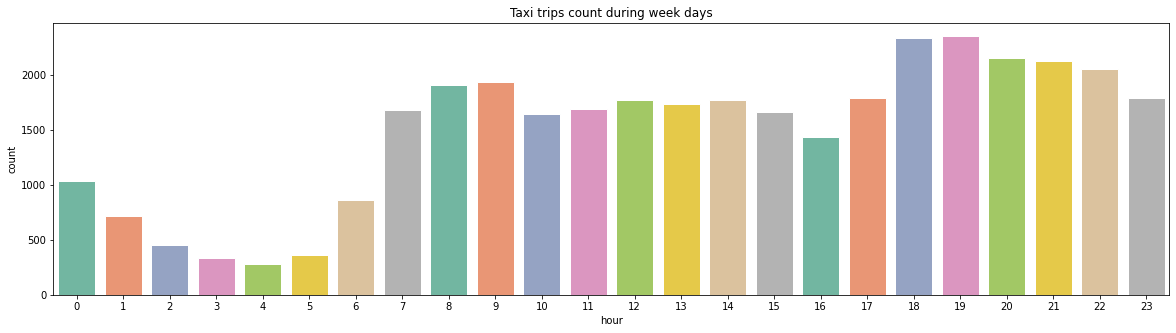

In [ ]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week days')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <=4)], palette='Set2')

We see that during the weekdays the count of trips start to peak from 8 am and is highest at 9am. In the evening the peak is at 6pm and 7pm.

**2. Plot a countplot to check the peak hours during weekends**

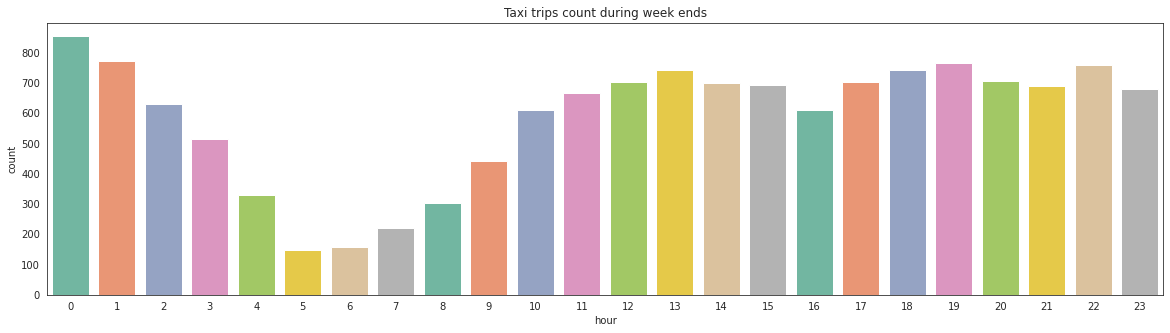

In [ ]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week ends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <=6)], palette='Set2')

We see that during the weekends the count of trips is high after 12 midnight to 3am to 4am. This pattern is different from the weekdays. In the evening the demand is almost evenly high after 6pm till late night except.

<a id='Mean_Fare'></a>
### 4.2.2 Mean fare for each hour during weekdays and weekends

We will check the mean fares for each hour during the weekdays and weekends.

**1. Compute the hourly mean fare for weekdays and weekends**

In [ ]:
# Set the days in the dataset as week days and week ends
week_days = df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <= 4)]
week_ends = df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <= 6)]
# compute the mean fare amount over the week day and week end.
# use groupby('hour') to get the mean fare for each hour
week_days_fare = week_days.groupby(['hour']).amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).amount.mean().to_frame().reset_index()

**2. Plot the mean fare**

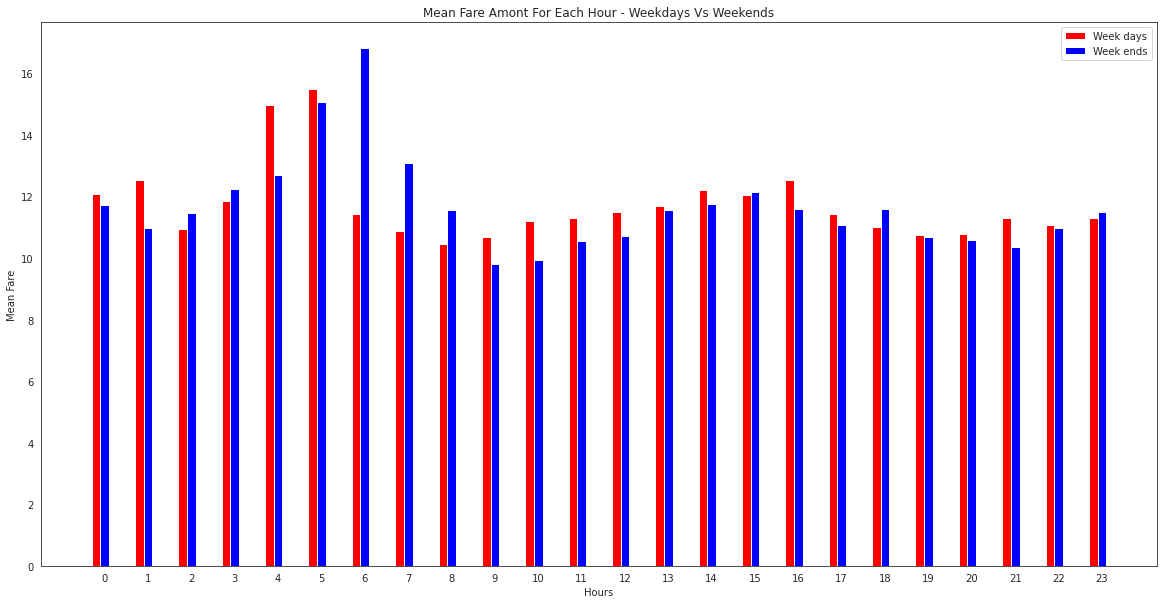

In [ ]:
# hours
x = np.array(week_days_fare.hour)
# an array of week day fare 
y = np.array(week_days_fare.amount)
# an array of week end fare
z = np.array(week_ends_fare.amount)

# Set the figure size, title, x and y labels
plt.figure(figsize = (20,10))
plt.title('Mean Fare Amont For Each Hour - Weekdays Vs Weekends')
plt.xlabel('Hours')
plt.ylabel('Mean Fare')
# Pass the three integers. The value of these integer should be less that 10
ax=plt.subplot(1,1,1)
ax.bar(x-0.2, y, width=0.2, color='red', align='center', label = 'Week days')
ax.bar(x, z, width=0.2, color='blue', align='center', label = 'Week ends')
plt.xticks(range(0,24))
plt.legend()
plt.show()


We notice that the mean fares for each hour are different for week days and week ends. Mean fare for weekdays during morning hours 6,7 and 8 is lmuch ess compared to weekends.

<a id='Distribution'></a>
### 4.2.3 Distribution of key numerical vairables

**1. Distribution of fare 'amount'**

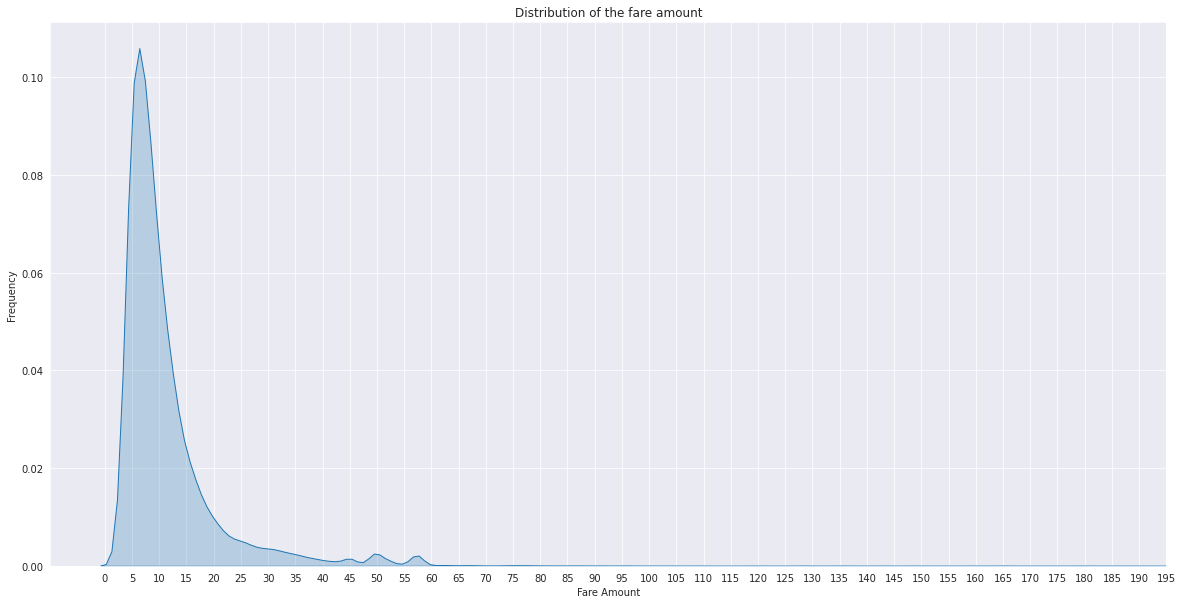

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df_taxi.amount, shade=True)


We can see that most the trips have a fare amount of 2 to 20 dollars. There are a few small peaks around 50 and 58 dollars as well.

**2. Distribustion of the travel distance in km**

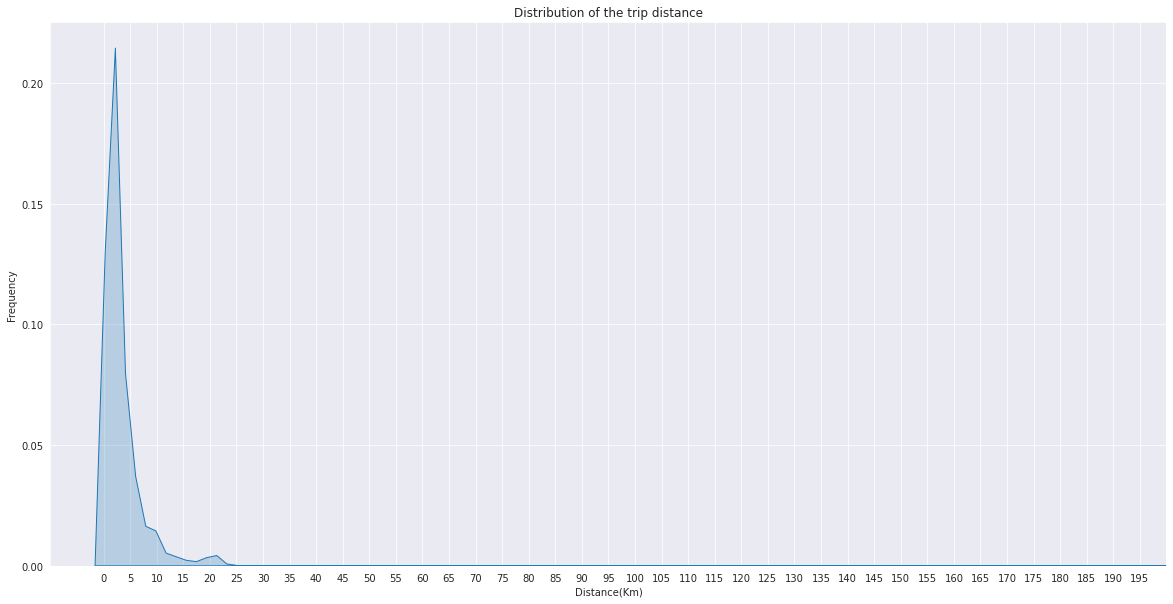

In [ ]:
plt.figure(figsize = (20,10))
sns.style = ('darkgrid')
plt.title("Distribution of the trip distance")
plt.xlabel("Distance(Km)")
plt.ylabel("Frequency")
plt.xlim(-10, 200)
plt.xticks(range(0,200,5))

sns.plot = sns.kdeplot(df_taxi[df_taxi.travel_dist_km<600].travel_dist_km, shade=True)

We can see that most the trips have a travel distance of 2.5 km to 25 km. There are a few instances of 0 km as well.

<a id='Random_Forest'></a>
# 5.  Random Forest

It is an example of the `Bagging` technique. It constructs multiple decision trees on randomly selected data samples. We can use the bootstrap sampling method to select the random samples of the same size from the dataset to construct multiple trees.

<a id='RF_Model'></a>
## 5.1 Random Forest Model

In this section we build a model using random forest regressor.

**1. Split the data into features and target dataframes**

Store the amount variable which is the target variable, into y.

In [ ]:
# select only the target variable 'amount' and store it in dataframe 'y'
y = pd.DataFrame(df_taxi['amount'])

Now, use this 'y' as a target variable to build the classification models.

In [ ]:
# use 'drop()' to remove the variable 'amount' from df_taxi
# 'axis = 1' drops the corresponding column(s)
X = df_taxi.drop('amount',axis = 1)

In [ ]:
X.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


Use this 'X' as a set of predictors to build the model.

**2. Split the data into training and test sets**

In [ ]:

# split data into train subset and test subset for predictor and target variables
# 'test_size' returns the proportion of data to be included in the test set
# set 'random_state' to generate the same dataset each time you run the code 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# check the dimensions of the train & test subset for 
# print dimension of predictors train set
print("The shape of X_train is:",X_train.shape)

# print dimension of predictors test set
print("The shape of X_test is:",X_test.shape)

# print dimension of target train set
print("The shape of y_train is:",y_train.shape)

# print dimension of target test set
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (34992, 11)
The shape of X_test is: (14997, 11)
The shape of y_train is: (34992, 1)
The shape of y_test is: (14997, 1)


**2. Build model using RandomForestRegressor**

In [ ]:
#intantiate the regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)

# fit the regressor with training dataset
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

**3. Predict the values using test set**

In [ ]:
# predict the values on test dataset using predict()
y_pred = rf_reg.predict(X_test)

**4. Compute accuracy measures**

Now we calculate accuray measures Root-mean-square-error (RMSE), R-squared and Adjusted R-squared.

In [ ]:


# Calculate MSE
rf_reg_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_MSE)

# Calculate RMSE
rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_RMSE)

Mean Squared Error (MSE): 19.630229608323198
Root Mean Squared Error (RMSE): 4.430601495093324


**5. Tabulate the results**

In [ ]:
# create the result table for all accuracy scores
# accuracy measures considered for model comparision are RMSE
# create a list of column names
cols = ['Model',  'MSE', 'RMSE']

# create a empty dataframe of the colums
# columns: specifies the columns to be selected
result_tabulation = pd.DataFrame(columns = cols)

# compile the required information
rf_reg_metrics = pd.Series({'Model': "Random Forest ",
                     'MSE': rf_reg_MSE,
                     'RMSE': rf_reg_RMSE     
                   })

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

# print the result table
result_tabulation

,Model,MSE,RMSE
0,Random Forest,19.630230,4.430601


<a id='RF_CV'></a>
## 5.2 Random Forest with GridSearchCV

Now we show how a decision tree is optimized by cross-validation, which is done using the `GridSearchCV()` from sklearn library.

The performance of the selected hyperparameters and trained model is then measured on the test set that was not used during the model building.

**1. Use GridSearch to obtain the optimal values of hyperparameters**

In [ ]:
# create a dictionary with hyperparameters and its values
# pass the n_estimators 
# pass the list of values to 'min_samples_split' that assigns minimum number of samples to split an internal node
# pass the list of values to 'max_depth' that assigns maximum depth of the tree
# pass the list of values to 'min_samples_leaf' that assigns minimum number of samples required at the terminal/leaf node
# pass the list of values to 'max_leaf_nodes' that assigns maximum number of leaf nodes in the tree
tuned_paramaters = [{'n_estimators': [ 85, 100],
                     'min_samples_split': [15,20],
                     'max_depth': [8, 10]
                     #'min_samples_leaf': [5,10],
                     #'max_leaf_nodes': [10, 15]
                    }]

In [ ]:
# instantiate the 'RandomForestRegressor' 
# pass the 'random_state' to obtain the same samples for each time you run the code
rf_reg_CV= RandomForestRegressor(random_state = 10)

# use GridSearchCV() to find the optimal value of the hyperparameters
# n_estimator: pass the decision tree classifier model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 10
grid = GridSearchCV(estimator = rf_reg_CV, 
                         param_grid = tuned_paramaters, 
                         cv = 10)

# fit the model on X_train and y_train using fit()
dt_grid = grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest regressor: ', dt_grid.best_params_, '\n')

Best parameters for random forest regressor:  {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 85} 



**2. Build the model using the hyperparameters obtained in step 1**

In [ ]:
# instantiate the 'RandomForestRegressor'
# 'best_params_' returns the dictionary containing best parameter values and parameter name  
# 'get()' returns the value of specified parameter
# pass the 'random_state' to obtain the same samples for each time you run the code
dt_grid_model = RandomForestRegressor(n_estimators = dt_grid.best_params_.get('n_estimators'),
                                       max_depth = dt_grid.best_params_.get('max_depth'),
                                       #max_leaf_nodes = dt_grid.best_params_.get('max_leaf_nodes'),
                                       #min_samples_leaf = dt_grid.best_params_.get('min_samples_leaf'),
                                       min_samples_split = dt_grid.best_params_.get('min_samples_split'),
                                       random_state = 10)

# use fit() to fit the model on the train set
dt_grid_model = dt_grid_model.fit(X_train, y_train)

**3. Predict the values using test set**

In [ ]:
# predict the class labels using 'X_test'
y_pred = dt_grid_model.predict(X_test)

**4. Compute accuracy measures**

Now we calculate accuray measures Root-mean-square-error (RMSE), R-squared and Adjusted R-squared.

In [ ]:
# calculate MAE

                                         
# calculate MSE
rf_reg_CV_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_CV_MSE)
                                         
# calculate RMSE
rf_reg_CV_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_CV_RMSE)

Mean Squared Error (MSE): 19.952915628853532
Root Mean Squared Error (RMSE): 4.466868660354089


**5. Tabulate the results**

In [ ]:
# create the result table for all accuracy scores
# accuracy measures considered for model comparision are MAE, MSE, RMSE
# create a list of column names
#cols = ['Model', 'MAE', 'MSE', 'RMSE']

# create a empty dataframe of the colums
# columns: specifies the columns to be selected
#result_tabulation = pd.DataFrame(columns = cols)

# compile the required information
rf_reg_metrics = pd.Series({'Model': "Random Forest ",
                     'MSE': rf_reg_CV_MSE,
                     'RMSE': rf_reg_CV_RMSE     
                   })

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

# print the result table
result_tabulation

,Model,MSE,RMSE
0,Random Forest,19.630230,4.430601
1,Random Forest,19.952916,4.466869
